In [1]:
import ibpmodel as ibp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timezone, timedelta, date
from viresclient import SwarmRequest
#pip install lxml

## functions

In [2]:
def downloadfn(dates):
    '''Download Solar Radio Flux for specified date(s).
    
    Parameters
    ----------
    dates : datetime or list of datetimes
    
    Returns
    -------
    list of numpy.float64
        Solar Radio Flux
    '''
    def loaddf(year):
        df = pd.read_html(f'https://spaceweather.gc.ca/forecast-prevision/solar-solaire/solarflux/sx-5-flux-en.php?year={year}')[0]
        return df
    
    def getfn(df,date):
        return df[ (df.Date == date.strftime("%Y-%m-%d")) & (df.Time == "20:00:00") ]["Observed Flux"].values[0]
    
    if isinstance(dates, datetime):
        years = [ dates.year ]
        dates = [ dates ]
    elif isinstance(dates, list):
        years = [ dates[0].year ]
    else: 
        raise TypeError(f"must be datetime or list of datetimes")
        
    df_fn = loaddf(years[0])
    fn = []
    
    for d in dates:
        y = d.year
        if y not in years:
            df_fn = pd.concat([df_fn, loaddf(y)])
            fn.append(getfn(df_fn, d))
            years.append(y) 
        else:
            fn.append(getfn(df_fn, d))
       
    return fn

In [3]:
def getlt(datum, lon):
    '''Output of the day of the year and local time for specifying date(s) and longitude(s).
    
    Parameters
    ----------
    datum : datetime or list of datetimes
    lon : int or list of int
        The geographical longitude, ``-180 <= longitude <= 180``.
    
    Returns
    -------
    tupel
        contains (list of) day(s) of the year and (list of) local time(s)
    '''
    def calclt(date, lon):
        return round((date.hour + date.minute/60 + date.second/3600 + 24*lon/360) % 24, 1)
    
    if isinstance(datum, datetime):
        doys = int(datum.strftime('%j'))
        lts = calclt(datum, lon)

    elif isinstance(datum, list):
        doys = []
        lts = []
        for d, l in zip(datum, lon):
            doys.append(int(d.strftime('%j')))
            lts.append(calclt(d,l))
        
    return (doys, lts)

In [4]:
def calcindex(df):
    '''Calculation of the IBP index. If Solar Radio Flux lower than 80 the IBP index is set to -1.
    
    Parameters
    ----------
    df : pandas.DataFrame (with columns Doy, Lon, LT and F10.7)
    
    Returns
    -------
    pandas.DataFrame
        contains the columns: Doy (Day(s) of the year), Month (Month(s) from the day of the year), 
        Lon (Longitude(s)), LT (Local Time(s)), F10.7 (solar index(es)), IBP (Ionospheric Bubble Index, value(s) between 0.0 and 1.0).
    '''
    def calcibp(index, row):
        df = ibp.calculateIBPindex(day_month=int(row["Doy"]), longitude=row["Lon"], local_time=row["LT"], f107=row["F10.7"])
        df = df.set_index([pd.Index([index])])
        return df
    
    index_sort = df.index
    
    tmp = df[ (df["F10.7"] < 80) ].copy()
    tmp["IBP"] = -1
    tmp['Month'] = [ int(datetime.strptime(f"2023-{t}","%Y-%j").strftime('%m')) for t in tmp.Doy ]
    tmp['Month'] = tmp['Month'].astype(int)
    
    di = pd.DataFrame(columns=tmp.columns)
    
    i = 0
    for index, row in df[ (df["F10.7"] >= 80) ].iterrows():
        if i == 0:
            di = calcibp(index, row)
            i = 1
        else:
            ib = calcibp(index, row)
            di = pd.concat([di, ib])

    di = pd.concat([di, tmp])
    di = di.reindex(index_sort)
    
    return di[['Doy','Month','Lon','LT','F10.7','IBP']]

In [5]:
def satelliteIBP(datum, lon):
    '''Calculation of the IBP index at the specified time and longitude
    
    Parameters
    ----------
    datum : list of datetime(s)
    lon : list of int(s)
        The geographical longitude, ``-180 <= longitude <= 180``.
        
    Returns
    -------
    numpy.float64
        IBP index (Ionospheric Bubble Index, values between 0.0 and 1.0)

    '''
    df = pd.DataFrame(columns=["Doy", "Lon", "LT", "F10.7"], index=datum) 
    df['Lon'] = lon
    df['F10.7'] = downloadfn(datum)
    df["Doy"], df["LT"] = getlt(datum, lon)
        
    return calcindex(df)

In [6]:
def globalIBP(datum, fn=150):
    '''Calculation of the IBP index for all longitudes at the specified time.
    
    Parameters
    ----------
    datum : datetime
        
    Returns
    -------
    pandas.DataFrame
        contains the columns: Doy (Day of the year), Month (Month from the day of the year), 
        Lon (Longitudes), LT (Local Times), F10.7 (solar index), IBP (Ionospheric Bubble Index, values between 0.0 and 1.0).
    '''
    df = pd.DataFrame(columns=["Doy", "Lon", "LT", "F10.7"])
    df["Lon"] = np.arange(-180,180)
    df["Doy"], df["LT"] = getlt(datum, df["Lon"])
    
    if datum.date() >= datetime.now().replace(tzinfo=timezone.utc).date():
        df["F10.7"] = fn
    else:
        df["F10.7"] = downloadfn(datum)[0]
    
    return calcindex(df)

# Examples

## IBP index around the earth at specific time

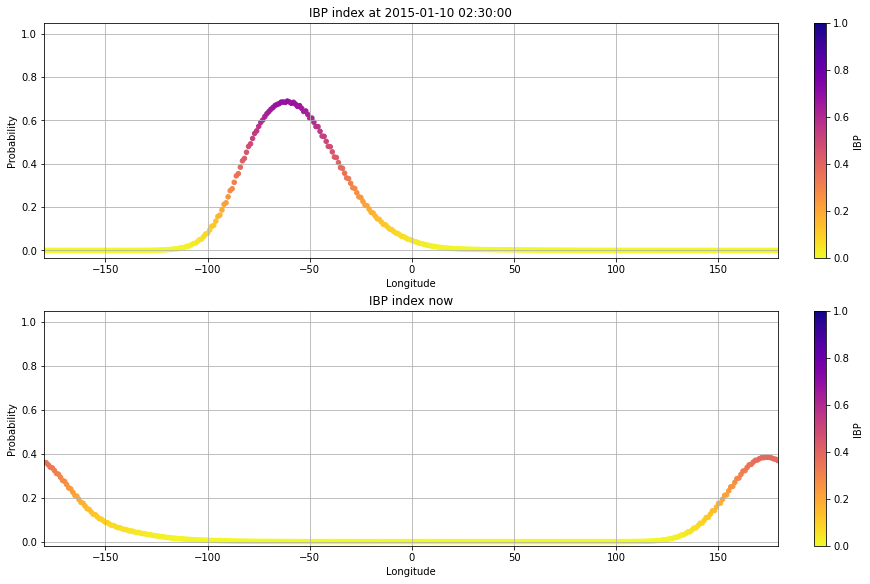

In [7]:
datum = datetime(2015, 1, 10, 2, 30).replace(tzinfo=timezone.utc)
#datum = datetime(2016, 4, 21, 22,50,0).replace(tzinfo=timezone.utc)

df1 = globalIBP(datum)
df2 = globalIBP(datetime.now())

fig, ax = plt.subplots(2,1,figsize=(12, 8), layout='constrained')
df1.plot.scatter(x='Lon', y='IBP', title=f'IBP index at {datum.strftime("%Y-%m-%d %H:%M:%S")}', 
        xlabel='Longitude', ylabel='Probability', grid=True, xlim=(-180,179),
        c='IBP', colormap='plasma_r', vmin=0, vmax=1, ax=ax[0],
        sharex=False)
# sharex=False - must be there because there is still a bug and xlabel and tickmarks will not appear otherwise
df2.plot.scatter(x='Lon', y='IBP', title=f'IBP index now', 
        xlabel='Longitude', ylabel='Probability', grid=True, xlim=(-180,179),
        c='IBP', colormap='plasma_r', vmin=0, vmax=1, ax=ax[1],
        sharex=False)

for a in ax:
    a.set_ylim(top=1.05)

plt.show()

## IBP Index along the orbit of a satellite

#### Download IBI data for Satellite B

In [8]:
request = SwarmRequest()
sat = 'B'
starttime = datetime(2022, 11, 26, 22,10,0).replace(tzinfo=timezone.utc)
endtime = datetime(2022, 11, 28, 23,50,0).replace(tzinfo=timezone.utc)

#starttime = datetime(2016, 4, 19, 2,10,0).replace(tzinfo=timezone.utc)
#endtime = datetime(2016, 4, 21, 22,50,0).replace(tzinfo=timezone.utc)

request.set_collection(f"SW_OPER_IBI{sat}TMS_2F")
request.set_products(measurements=request.available_measurements("IBI"))
data = request.get_between(starttime, endtime)

Processing:    0%|          |  [ Elapsed: 00:00, Remaining: ? ] [1/1] 

Downloading:   0%|          |  [ Elapsed: 00:00, Remaining: ? ] (8.231MB)

In [9]:
df = data.as_dataframe()

df = df[ (df.Bubble_Index > -1) ]

df['day'] = pd.to_datetime(df.index).values.astype(np.int64)/1000000000
df['lon'] = round(df['Longitude']).astype('int')
df['round'] = df.index.strftime('%Y-%m-%d') + ":" + df['lon'].astype('str')

#display(df.head())

#df.plot(x="Longitude", y="Bubble_Index", marker=".", linewidth=0, grid=True, figsize=(9, 5))
#plt.show()

#### Summarize the data to integer longitude and Calculation of IBP index

In [10]:
gf = df.groupby("round").mean()

gf['datetime'] = pd.to_datetime(gf['day'].astype(int), unit='s')
del gf["Latitude"], gf["Flags_B"], gf["Flags_q"], gf["Radius"], gf["Flags_F"]

gf['IBP'] = satelliteIBP(gf['datetime'].tolist(), gf['lon'].astype(int).tolist())['IBP'].values

display(gf)

,Flags_Bubble,Bubble_Probability,Longitude,Bubble_Index,day,lon,datetime,IBP
round,,,,,,,,
2022-11-26:-30,0.345650,0.001673,-29.881648,0.172825,1.669501e+09,-30.0,2022-11-26 22:23:48,0.5411
2022-11-26:-31,0.367067,0.001777,-30.862981,0.183533,1.669502e+09,-31.0,2022-11-26 22:35:39,0.5414
2022-11-26:-53,0.000000,0.000000,-53.353350,0.000000,1.669507e+09,-53.0,2022-11-26 23:54:31,0.5597
2022-11-26:-54,0.120805,0.075678,-53.603178,0.100671,1.669507e+09,-54.0,2022-11-26 23:58:45,0.5562
2022-11-27:-101,0.000000,0.000000,-101.056665,0.000000,1.669518e+09,-101.0,2022-11-27 03:06:30,0.1580
...,...,...,...,...,...,...,...,...
2022-11-28:71,0.000000,0.000000,71.182739,0.000000,1.669650e+09,71.0,2022-11-28 15:38:56,0.1592
2022-11-28:72,0.000000,0.000000,72.048874,0.000000,1.669649e+09,72.0,2022-11-28 15:28:43,0.1531
2022-11-28:73,0.000000,0.000000,72.528193,0.000000,1.669649e+09,73.0,2022-11-28 15:21:21,0.1462


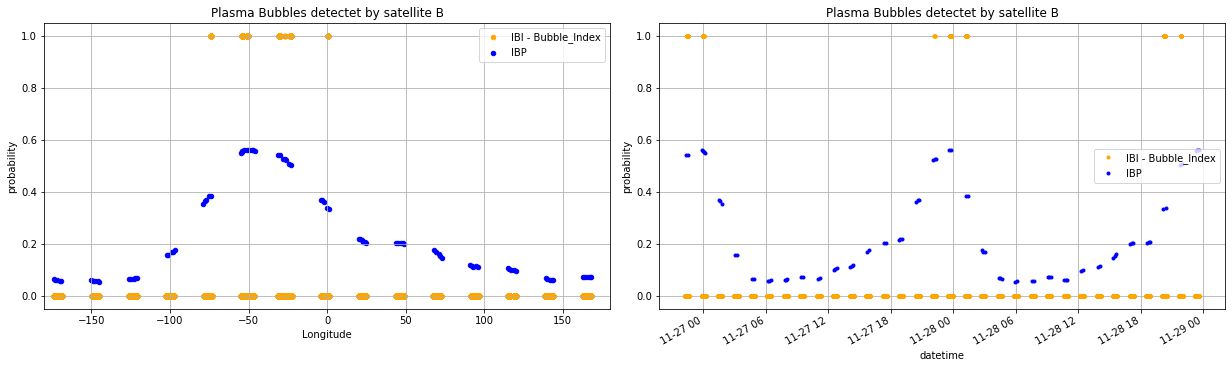

In [11]:
fig, axes = plt.subplots(1,2,figsize=(17, 5), layout='constrained')

df.plot(x="Longitude", y="Bubble_Index", ax=axes[0], color='orange', kind='scatter', label='IBI - Bubble_Index')
#df.plot(x="Longitude", y="Bubble_Probability", ax=axes[0], color='g', kind='scatter', label='IBI - Bubble_Probability')
gf.plot(x="lon", y="IBP", kind="scatter", ax=axes[0], color='b', label='IBP')

df.plot(y="Bubble_Index", ax=axes[1], color='orange', marker=".", linewidth=0, label='IBI - Bubble_Index')
#df.plot(x="Loy="Bubble_Probability", ax=axes[0], color='g', kind='scatter', label='IBI - Bubble_Probability')
gf.plot(x="datetime", y="IBP", marker=".", linewidth=0, ax=axes[1], color='b', label='IBP')


axes[0].set_xlabel('Longitude')
axes[0].set_xlim(-180,180)

for ax in axes:
    ax.set_ylabel('probability')
    ax.set_ylim(top=1.05)
    ax.legend()
    ax.set_title(f'Plasma Bubbles detectet by satellite {sat}')
    ax.grid()

plt.show() 